In [1]:
import airfrans as af
import matplotlib.pyplot as plt
import numpy as np
import os 


project_root = os.path.dirname(os.path.dirname(os.getcwd()))
PATH_TO_DATASET = os.path.join(project_root, "Dataset", 'Dataset')


In [2]:
simulation = af.Simulation(root = PATH_TO_DATASET, name = 'airFoil2D_SST_43.597_5.932_3.551_3.1_1.0_18.252', T = 298.15)

c:\Users\romai\anaconda3\envs\airfrans_download\lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


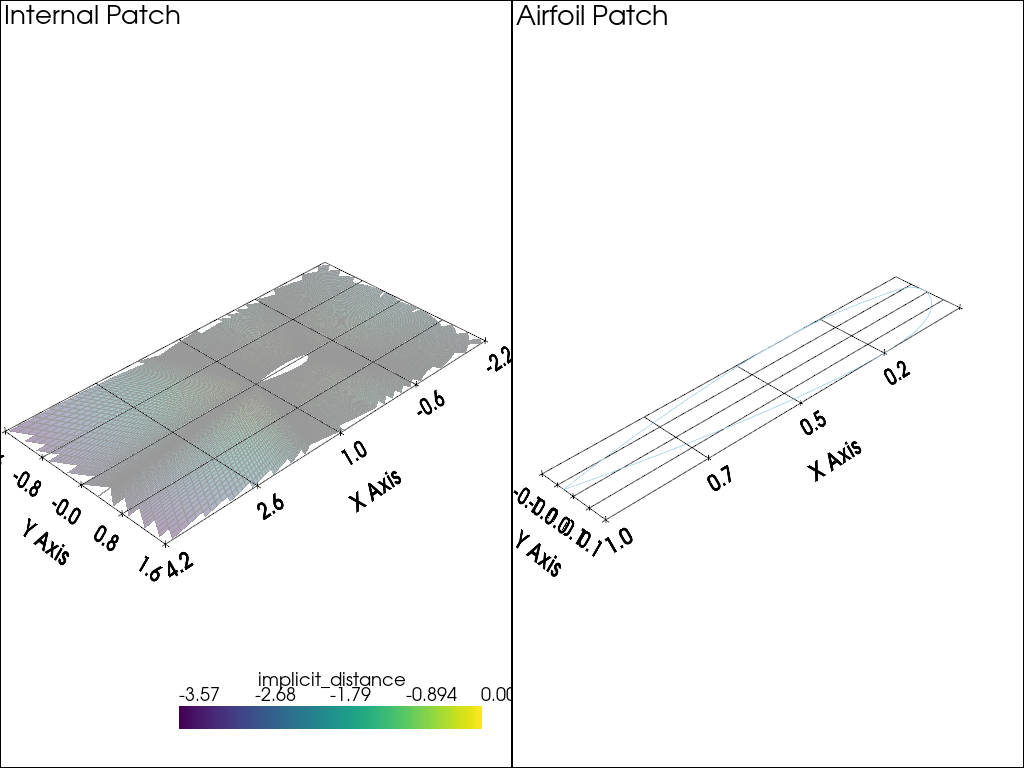

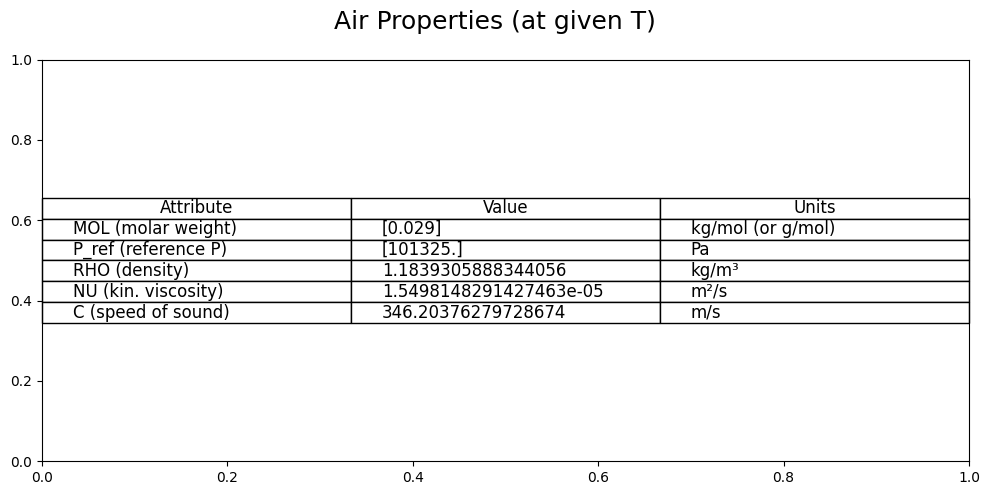

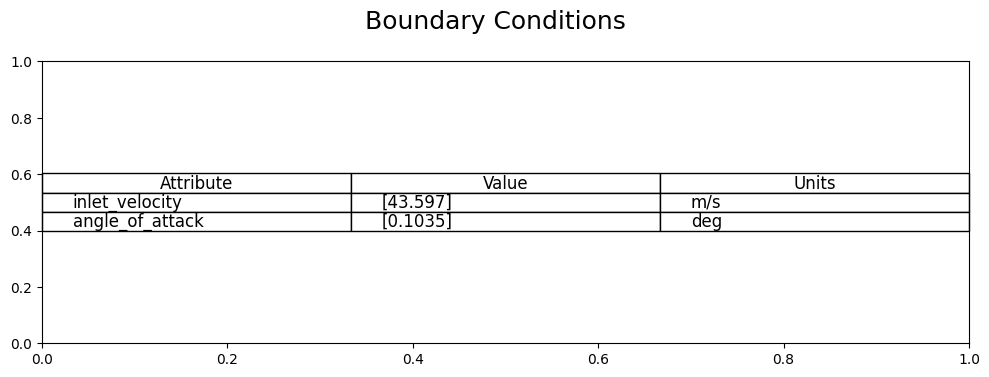

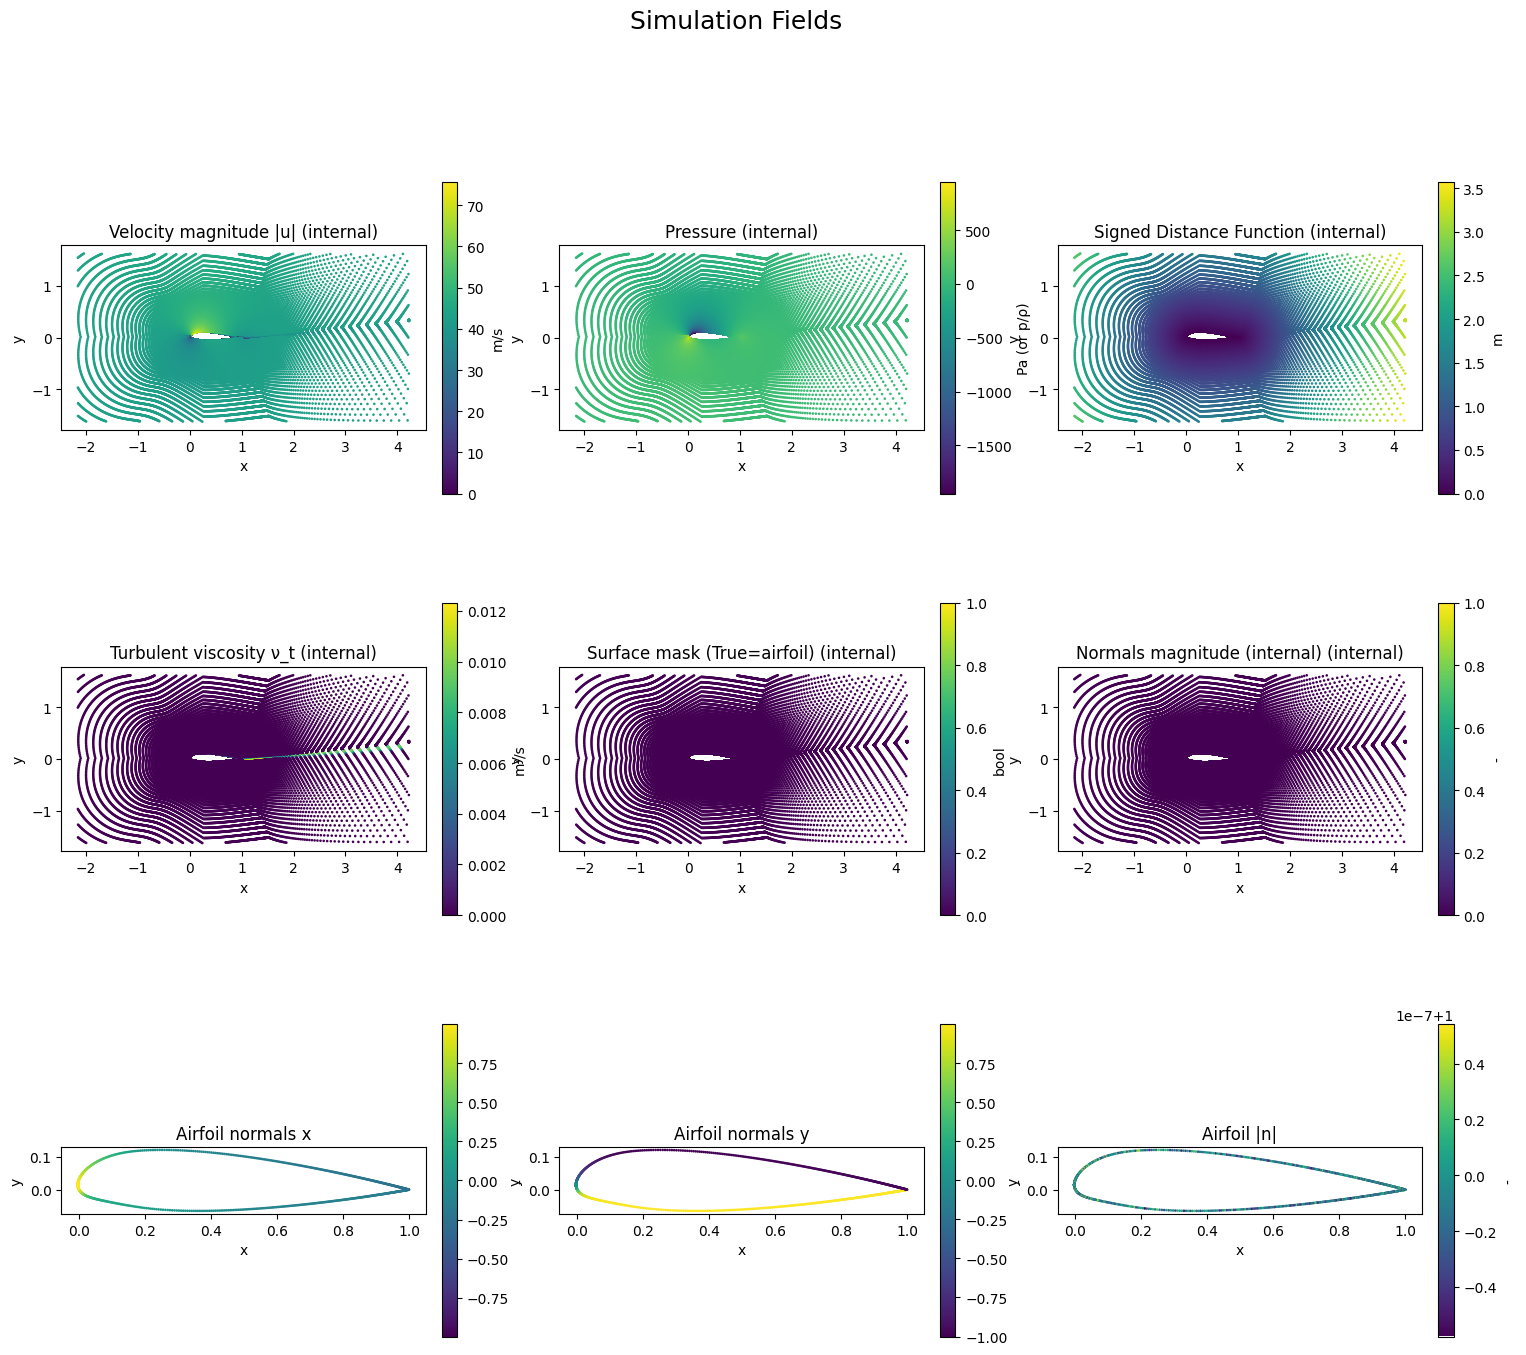

In [3]:
# ===== NICE, SEPARATED FIGURES FOR airfrans.Simulation =====
# 1) Air properties (scalars)
# 2) Boundary conditions (scalars/vectors) + mini schematic
# 3) Geometry (PyVista if available; 2D fallback)
# 4) Fields (NumPy arrays) with colorbars + optional velocity quiver

from matplotlib.gridspec import GridSpec

def get_attr(obj, name, default=None):
    return getattr(obj, name, default)

def to_array(x):
    """Return ndarray or None."""
    if x is None:
        return None
    return np.asarray(x)

def squeeze_1d(a):
    """Squeeze to 1D (N,) if possible; return None if invalid."""
    if a is None:
        return None
    a = np.asarray(a)
    a = np.squeeze(a)
    if a.ndim == 1:
        return a
    if a.ndim == 2 and a.shape[1] == 1:
        return a[:, 0]
    return None  # caller should pass component explicitly for vectors

def add_table_figure(title, rows):
    """
    Create a figure with a single table.
    rows: list of (label, value, units)
    """
    fig = plt.figure(figsize=(10, 3 + 0.4*len(rows)))
    fig.suptitle(title, fontsize=18, y=0.98)
    ax = fig.add_subplot(111)

    data = []
    for label, value, units in rows:
        if isinstance(value, (list, tuple, np.ndarray)):
            value_display = np.array(value).flatten()
            value_display = np.array2string(value_display, precision=4, separator=", ")
        else:
            value_display = f"{value}"
        data.append([label, value_display, units])

    table = ax.table(
        cellText=data,
        colLabels=["Attribute", "Value", "Units"],
        loc='center',
        cellLoc='left'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.2)
    fig.tight_layout()
    return fig

def add_colorbar_scatter(ax, x, y, c, title, vlabel):
    """Scatter with colorbar and neat defaults."""
    sc = ax.scatter(x, y, c=c, s=0.75)
    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect('equal', adjustable='box')
    cb = plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
    cb.set_label(vlabel)
    return sc

def safe_norm(vec):
    """Vector magnitude; returns (N,1) for consistency or None."""
    if vec is None:
        return None
    vec = to_array(vec)
    if vec.ndim == 1:
        return np.abs(vec)[:, None]
    if vec.ndim == 2:
        return np.linalg.norm(vec, axis=1, keepdims=True)
    return None

def lengths_match(a, b):
    return a is not None and b is not None and len(a) == len(b)

# ---------------------------
# 1) AIR PROPERTIES
# ---------------------------
air_rows = [
    ("MOL (molar weight)",   get_attr(simulation, "MOL"),   "kg/mol (or g/mol)"),
    ("P_ref (reference P)",  get_attr(simulation, "P_ref"), "Pa"),
    ("RHO (density)",        get_attr(simulation, "RHO"),   "kg/m³"),
    ("NU (kin. viscosity)",  get_attr(simulation, "NU"),    "m²/s"),
    ("C (speed of sound)",   get_attr(simulation, "C"),     "m/s"),
]
fig1 = add_table_figure("Air Properties (at given T)", air_rows)

# ---------------------------
# 2) BOUNDARY CONDITIONS
# ---------------------------
inlet_vel = get_attr(simulation, "inlet_velocity")
aoa = get_attr(simulation, "angle_of_attack")

bc_rows = [
    ("inlet_velocity", inlet_vel, "m/s"),
    ("angle_of_attack", aoa, "deg"),
]
fig2 = add_table_figure("Boundary Conditions", bc_rows)


# ---------------------------
# 3) GEOMETRY (PyVista objects)
# ---------------------------
use_pyvista = False
internal_mesh = None
airfoil_mesh = None
try:
    import pyvista as pv
    internal_mesh = get_attr(simulation, "internal")
    airfoil_mesh = get_attr(simulation, "airfoil")
    if internal_mesh is not None or airfoil_mesh is not None:
        use_pyvista = True
except Exception:
    use_pyvista = False

if use_pyvista:
    pl = pv.Plotter(title="Reference Geometry (PyVista)", shape=(1, 2))
    pl.subplot(0, 0)
    pl.add_text("Internal Patch", font_size=12)
    if internal_mesh is not None:
        pl.add_mesh(internal_mesh, show_edges=True, opacity=0.4)
    pl.show_bounds(grid='front', location='outer', ticks='both')

    pl.subplot(0, 1)
    pl.add_text("Airfoil Patch", font_size=12)
    if airfoil_mesh is not None:
        pl.add_mesh(airfoil_mesh, show_edges=True)
    pl.show_bounds(grid='front', location='outer', ticks='both')
    pl.show()
else:
    # 2D fallback using node positions (if available)
    airfoil_pos = to_array(get_attr(simulation, "airfoil_position"))
    pos = to_array(get_attr(simulation, "position"))

    fig3 = plt.figure(figsize=(10, 5))
    fig3.suptitle("Reference Geometry (2D fallback)", fontsize=18, y=0.98)
    gs = GridSpec(1, 2, figure=fig3)

    ax31 = fig3.add_subplot(gs[0, 0])
    ax31.set_title("Internal Patch (nodes)")
    if pos is not None:
        ax31.scatter(pos[:, 0], pos[:, 1], s=0.2)
    ax31.set_aspect('equal', adjustable='box')
    ax31.set_xlabel("x"); ax31.set_ylabel("y")

    ax32 = fig3.add_subplot(gs[0, 1])
    ax32.set_title("Airfoil Patch (nodes)")
    if airfoil_pos is not None:
        ax32.scatter(airfoil_pos[:, 0], airfoil_pos[:, 1], s=1.0)
    ax32.set_aspect('equal', adjustable='box')
    ax32.set_xlabel("x"); ax32.set_ylabel("y")
    fig3.tight_layout()

# ---------------------------
# 4) FIELDS (NumPy arrays)
# ---------------------------
pos          = to_array(get_attr(simulation, "position"))
airfoil_pos  = to_array(get_attr(simulation, "airfoil_position"))
vel          = to_array(get_attr(simulation, "velocity"))
pressure     = to_array(get_attr(simulation, "pressure"))
sdf          = to_array(get_attr(simulation, "sdf"))
nu_t         = to_array(get_attr(simulation, "nu_t"))
surface      = to_array(get_attr(simulation, "surface"))
normals_int  = to_array(get_attr(simulation, "normals"))
normals_air  = to_array(get_attr(simulation, "airfoil_normals"))

# Derived quantities
vel_mag          = safe_norm(vel)               # (N,1) or None
normals_mag_int  = safe_norm(normals_int)       # (N,1) or None
normals_mag_air  = safe_norm(normals_air)       # (M,1) or None

# Prepare fields list (name, array, units, domain)
# domain: "internal" uses pos; "airfoil" uses airfoil_pos
fields = [
    ("Velocity magnitude |u|",           vel_mag,             "m/s",      "internal"),
    ("Pressure",                         pressure,            "Pa (or p/ρ)", "internal"),
    ("Signed Distance Function",         sdf,                 "m",        "internal"),
    ("Turbulent viscosity ν_t",          nu_t,                "m²/s",     "internal"),
    ("Surface mask (True=airfoil)",      surface,             "bool",     "internal"),
    ("Normals magnitude (internal)",     normals_mag_int,     "-",        "internal"),
    ("Airfoil normals x",                normals_air[:, 0:1] if normals_air is not None and normals_air.shape[1] >= 1 else None, "-", "airfoil"),
    ("Airfoil normals y",                normals_air[:, 1:2] if normals_air is not None and normals_air.shape[1] >= 2 else None, "-", "airfoil"),
    ("Airfoil |n|",                      normals_mag_air,     "-",        "airfoil"),
]

# Collect plottable items with proper positions
plot_items = []
for name, arr, units, domain in fields:
    if arr is None:
        continue
    arr = to_array(arr)
    if arr.ndim == 2 and arr.shape[1] == 1:
        arr = arr[:, 0]
    if domain == "internal" and lengths_match(pos, arr):
        plot_items.append((domain, name, arr, units))
    elif domain == "airfoil" and lengths_match(airfoil_pos, arr):
        plot_items.append((domain, name, arr, units))

n = len(plot_items)
cols = 3
rows = max(1, int(np.ceil(n / cols)))

fig4 = plt.figure(figsize=(6*cols, 5*rows))
fig4.suptitle("Simulation Fields", fontsize=18, y=0.995)
gs = GridSpec(rows, cols, figure=fig4, wspace=0.25, hspace=0.35)

for i, (domain, name, arr, units) in enumerate(plot_items):
    r, c = divmod(i, cols)
    ax = fig4.add_subplot(gs[r, c])
    if domain == "internal":
        add_colorbar_scatter(ax, pos[:, 0], pos[:, 1], arr, f"{name} (internal)", units)
    else:
        add_colorbar_scatter(ax, airfoil_pos[:, 0], airfoil_pos[:, 1], arr, name, units)

plt.show()


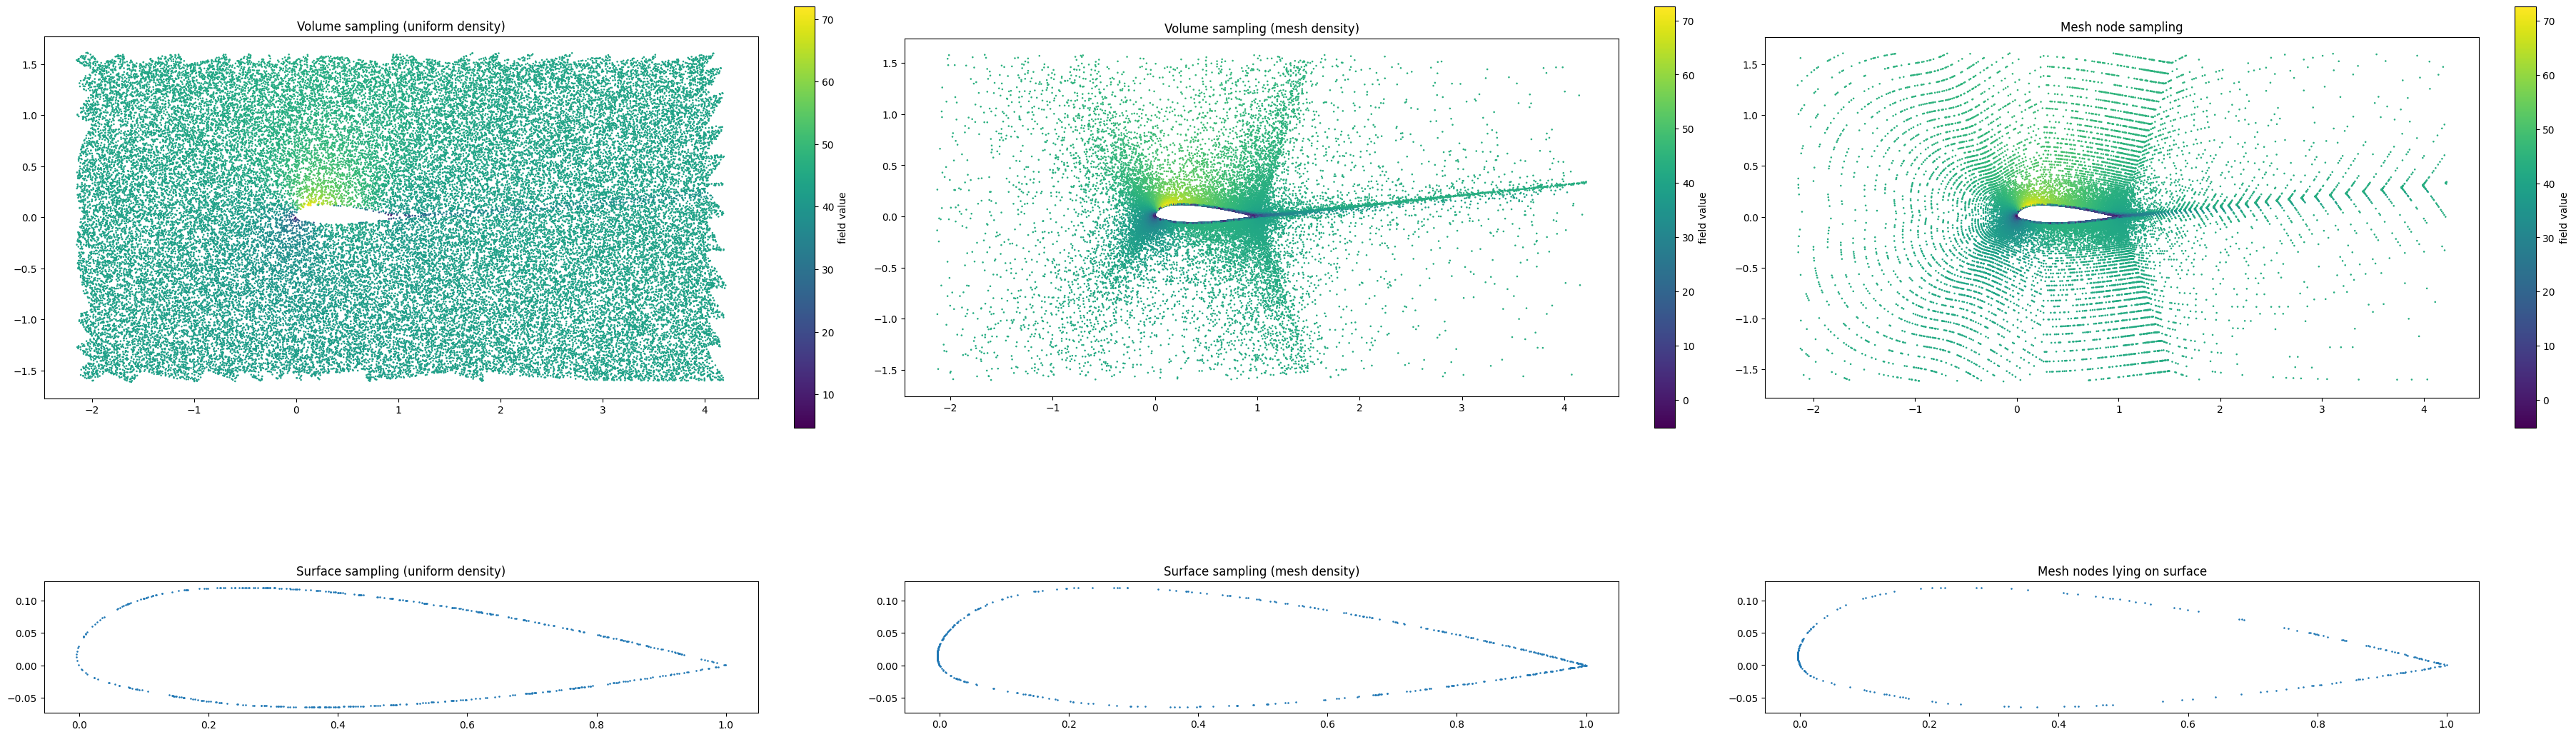

In [4]:
# ==================== METHODS: Sampling ====================
# airfrans.Simulation provides sampling utilities:
# - sampling_volume:    sample points inside the internal domain
# - sampling_surface:   sample points on the airfoil surface
# - sampling_mesh:      sample nodes from the internal mesh

# Seed for reproducibility
seed = 0

# Volume sampling
sampling_volume_uniform = simulation.sampling_volume(seed, 50000, density='uniform')
sampling_volume_mesh    = simulation.sampling_volume(seed, 50000, density='mesh_density')

# Surface sampling
sampling_surface_uniform = simulation.sampling_surface(seed, 500, density='uniform')
sampling_surface_mesh    = simulation.sampling_surface(seed, 500, density='mesh_density')

# Mesh node sampling
sampling_mesh         = simulation.sampling_mesh(seed, 50000)
sampling_mesh_surface = sampling_mesh[sampling_mesh[:, 2].astype(bool)]

# ---- Visualization ----
fig, ax = plt.subplots(2, 3, figsize=(36, 12), constrained_layout=True)

# Volume
sc0 = ax[0, 0].scatter(sampling_volume_uniform[:, 0], sampling_volume_uniform[:, 1],
                       c=sampling_volume_uniform[:, 3], s=0.75)
ax[0, 0].set_title("Volume sampling (uniform density)")
ax[0, 0].set_aspect("equal", adjustable="box")
plt.colorbar(sc0, ax=ax[0, 0], label="field value")

sc1 = ax[0, 1].scatter(sampling_volume_mesh[:, 0], sampling_volume_mesh[:, 1],
                       c=sampling_volume_mesh[:, 3], s=0.75)
ax[0, 1].set_title("Volume sampling (mesh density)")
ax[0, 1].set_aspect("equal", adjustable="box")
plt.colorbar(sc1, ax=ax[0, 1], label="field value")

sc2 = ax[0, 2].scatter(sampling_mesh[:, 0], sampling_mesh[:, 1],
                       c=sampling_mesh[:, 8], s=0.75)
ax[0, 2].set_title("Mesh node sampling")
ax[0, 2].set_aspect("equal", adjustable="box")
plt.colorbar(sc2, ax=ax[0, 2], label="field value")

# Surface
ax[1, 0].scatter(sampling_surface_uniform[:, 0], sampling_surface_uniform[:, 1], s=0.75)
ax[1, 0].set_title("Surface sampling (uniform density)")
ax[1, 0].set_aspect("equal", adjustable="box")

ax[1, 1].scatter(sampling_surface_mesh[:, 0], sampling_surface_mesh[:, 1], s=0.75)
ax[1, 1].set_title("Surface sampling (mesh density)")
ax[1, 1].set_aspect("equal", adjustable="box")

ax[1, 2].scatter(sampling_mesh_surface[:, 0], sampling_mesh_surface[:, 1], s=0.75)
ax[1, 2].set_title("Mesh nodes lying on surface")
ax[1, 2].set_aspect("equal", adjustable="box")

plt.show()
# ===========================================================


## Reference vs Current Fields in `airfrans.Simulation`

An instance of `airfrans.Simulation` stores **two versions** of the flow fields (`velocity`, `pressure`, `nu_t`, etc.):

1. **Current fields**  
   - These are the fields you can modify or replace.  
   - Example: setting them to zero, or filling them with the output of a surrogate model.  
   - Used when calling methods without the `reference=True` flag.  

2. **Reference fields**  
   - These are the original fields from the CFD simulation.  
   - They represent the *ground truth* data.  
   - Used when calling methods with `reference=True`.  

### Methods behavior

- `simulation.force()` → computed from **current fields**  
- `simulation.force(reference=True)` → computed from **reference fields**

- `simulation.force_coefficient()` → uses **current fields**  
- `simulation.force_coefficient(reference=True)` → uses **reference fields**

- `simulation.mean_squared_error()` → compares **current fields** against **reference fields**

- `simulation.reset()` → sets **current fields = reference fields**  
  → After reset, the mean squared error is exactly zero.

### In short
- **Current = prediction or modified state**  
- **Reference = CFD ground truth**  
- Methods allow you to compute forces, coefficients, and errors consistently between the two.


In [5]:
# --- Forces / Coefficients / MSE ---

# 1) Mettre les champs à zéro
simulation.velocity = np.zeros_like(simulation.velocity)
simulation.pressure = np.zeros_like(simulation.pressure)

# 2) Forces
print("simulation.force() ->", simulation.force())
# (Fx_total, Fx_pressure, Fx_viscous)

print("simulation.force(reference=True) ->", simulation.force(reference=True))
# mêmes trois vecteurs mais calculés avec le champ de référence

# 3) Coefficients de force
print("simulation.force_coefficient() ->", simulation.force_coefficient())
# (coeff_total, coeff_pressure, coeff_viscous)

print("simulation.force_coefficient(reference=True) ->", simulation.force_coefficient(reference=True))
# idem, mais avec le champ de référence

# 4) MSE par rapport à la référence
print("simulation.mean_squared_error() ->", simulation.mean_squared_error())
# array([MSE_velocity, MSE_pressure, MSE_turbulent_viscosity, MSE_surface])

# 5) Reset et vérification
simulation.reset()
print("simulation.mean_squared_error() après reset ->", simulation.mean_squared_error())
# devrait donner [0., 0., 0., 0.]


simulation.force() -> (array([0., 0.]), array([-0., -0.]), array([0., 0.]))
simulation.force(reference=True) -> (array([-79.14531492, 907.93140893]), array([-87.92142909, 906.79514981]), array([8.77611416, 1.13625912]))
simulation.force_coefficient() -> ((0.0, 0.0, 0.0), (0.0, 0.0, 0.0))
simulation.force_coefficient(reference=True) -> ((0.013430634660160565, 0.005568065068682372, 0.007862569591478193), (0.8098930901526409, 0.8096947336675802, 0.00019835648506073166))
simulation.mean_squared_error() -> [  1100.52840616    228.02913834 227577.73445435      0.        ]
simulation.mean_squared_error() après reset -> [0. 0. 0. 0.]


## Boundary layers plots

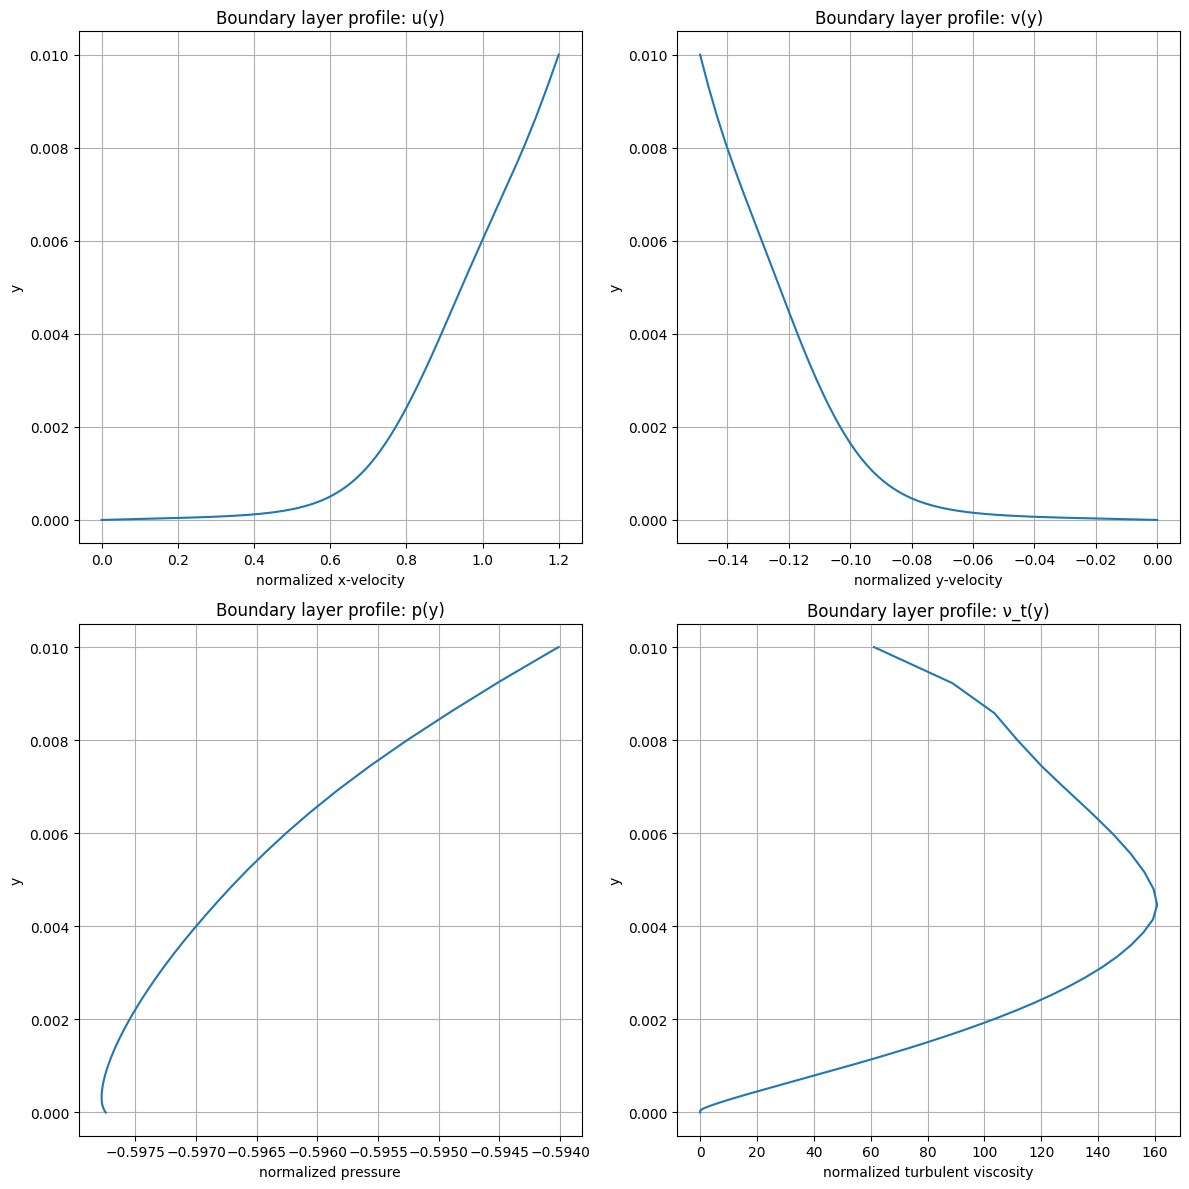

In [6]:

# Échantillonner la couche limite
boundary_layer = simulation.boundary_layer(x=0.5, y=0.01)

# boundary_layer structure (typique) :
# boundary_layer[0] = y (distance depuis la paroi)
# boundary_layer[1] = u (x-velocity normalisée)
# boundary_layer[2] = v (y-velocity normalisée)
# boundary_layer[3] = p (pression normalisée)
# boundary_layer[4] = nu_t (viscosité turbulente normalisée)

# ---- Plots 2×2 ----
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

# Normalized x-velocity
ax[0, 0].plot(boundary_layer[1], boundary_layer[0])
ax[0, 0].set_xlabel("normalized x-velocity")
ax[0, 0].set_ylabel("y")
ax[0, 0].set_title("Boundary layer profile: u(y)")
ax[0, 0].grid(True)

# Normalized y-velocity
ax[0, 1].plot(boundary_layer[2], boundary_layer[0])
ax[0, 1].set_xlabel("normalized y-velocity")
ax[0, 1].set_ylabel("y")
ax[0, 1].set_title("Boundary layer profile: v(y)")
ax[0, 1].grid(True)

# Normalized pressure
ax[1, 0].plot(boundary_layer[3], boundary_layer[0])
ax[1, 0].set_xlabel("normalized pressure")
ax[1, 0].set_ylabel("y")
ax[1, 0].set_title("Boundary layer profile: p(y)")
ax[1, 0].grid(True)

# Normalized turbulent viscosity
ax[1, 1].plot(boundary_layer[4], boundary_layer[0])
ax[1, 1].set_xlabel("normalized turbulent viscosity")
ax[1, 1].set_ylabel("y")
ax[1, 1].set_title("Boundary layer profile: ν_t(y)")
ax[1, 1].grid(True)

plt.tight_layout()
plt.show()


## Surface plots

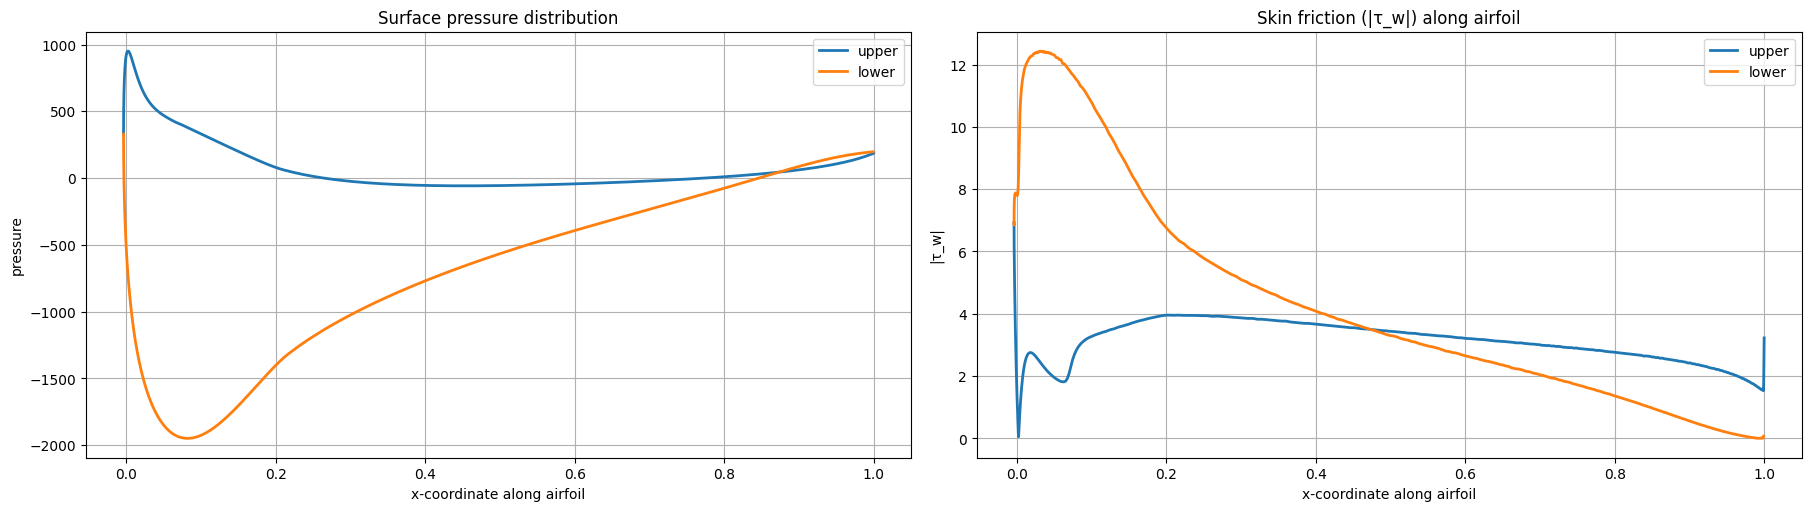

In [7]:

# Wall shear stress (vector) and its norm on surface nodes
wss = simulation.wallshearstress()
norm_wss = np.linalg.norm(wss[simulation.surface], axis=1)

# Extract surface arrays
x_s   = simulation.position[simulation.surface, 0]
p_s   = np.squeeze(simulation.pressure[simulation.surface])
n_s   = simulation.normals[simulation.surface]          # inward normals at surface

# Split into upper (n_y>0) and lower (n_y<0)
upper = n_s[:, 1] > 0
lower = n_s[:, 1] < 0

def sort_and_plot(ax, x, y, label):
    order = np.argsort(x)
    ax.plot(x[order], y[order], linewidth=2, label=label)

fig, ax = plt.subplots(1, 2, figsize=(18, 5), constrained_layout=True)

# Pressure
sort_and_plot(ax[0], x_s[upper], p_s[upper], "upper")
sort_and_plot(ax[0], x_s[lower], p_s[lower], "lower")
ax[0].set_title("Surface pressure distribution")
ax[0].set_xlabel("x-coordinate along airfoil")
ax[0].set_ylabel("pressure")
ax[0].grid(True)
ax[0].legend()

# Skin friction (|τ_w|)
sort_and_plot(ax[1], x_s[upper], norm_wss[upper], "upper")
sort_and_plot(ax[1], x_s[lower], norm_wss[lower], "lower")
ax[1].set_title("Skin friction (|τ_w|) along airfoil")
ax[1].set_xlabel("x-coordinate along airfoil")
ax[1].set_ylabel("|τ_w|")
ax[1].grid(True)
ax[1].legend()

plt.show()